In [3]:
import glob
import cv2
import mediapipe as mp
from tqdm.notebook import tqdm

img_paths = ['/data/michael/public_code/TED4Share/demo_images/demo_image_4.png'] #glob.glob('/data/michael/public_code/TED4Share/demo_images/*')
path2save = '.'

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

I0000 00:00:1746148430.397678 1334482 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746148430.411395 1335882 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.90.07), renderer: NVIDIA RTX A6000/PCIe/SSE2


W0000 00:00:1746148430.416181 1335858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746148430.431777 1335853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [4]:
eye_crop = image = None
x_min = x_max = y_min = y_max = 0
x_min_eye = x_max_eye = y_min_eye = y_max_eye = 0
x_coords = y_coords = None
image = None
def extract_eye_region(path, save_path):
    global eye_crop, x_min, x_max, y_min, y_max, image, x_coords, y_coords, x_min_eye, x_max_eye, y_min_eye, y_max_eye
    global image
    # Load image
    image = cv2.imread(path)
    try:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except :
        # print("Error converting image to RGB. Skipping this image.")
        # print(path)
        return  -2


    results = face_mesh.process(rgb_image)

    # Landmark indices for both eyes
    LEFT_EYE_LANDMARKS = [33, 133, 160, 159, 158, 157, 173, 246, 161, 144, 145, 153, 154, 155, 133, 474, 475, 476, 477]
    RIGHT_EYE_LANDMARKS = [362, 263, 387, 386, 385, 384, 398, 466, 388, 390, 373, 374, 380, 381, 382, 362, 469, 470, 471, 472]
    ALL_EYE_LANDMARKS = LEFT_EYE_LANDMARKS + RIGHT_EYE_LANDMARKS

    if results.multi_face_landmarks:
        h, w, _ = image.shape
        landmarks = results.multi_face_landmarks[0].landmark

        # Get (x, y) coordinates of all eye landmarks
        eye_points = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in ALL_EYE_LANDMARKS]

        # Compute bounding box
        x_coords, y_coords = zip(*eye_points)
        x_min_eye, x_max_eye = min(x_coords), max(x_coords)
        y_min_eye, y_max_eye = min(y_coords), max(y_coords)

        # Add padding
        padding_x = int(w*0.08) #100
        padding_y = int(h*0.23) #50
        padding_y = int((y_max_eye-y_min_eye)*2.5) #50
        padding_y_top = int((y_max_eye-y_min_eye)*2.75) #50
        padding_y_bottom = int((y_max_eye-y_min_eye)*2.5) #50
        
        # print(w, h)
        # print(f'w: {w}, h: {h}')
        # print(f'x_min_eye: {x_min_eye}, x_max_eye: {x_max_eye}, y_min_eye: {y_min_eye}, y_max_eye: {y_max_eye}')
        # print(f'x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}')
        # print()

        x_min = max(x_min_eye - padding_x, 0)
        y_min = max(y_min_eye - padding_y_bottom, 0)
        x_max = min(x_max_eye + padding_x, w)
        y_max = min(y_max_eye + padding_y_top, h)
        
        # Crop the region
        eye_crop = image[y_min:y_max, x_min:x_max]
        cv2.imwrite(f'{save_path}/{path.split('/')[-1]}', eye_crop)
    else:
        print("No face landmarks detected.")
        return  -1
    return 0

img_no_landmark = []
img_cvt_error = []

i = 0
for p in tqdm(img_paths):
    success = extract_eye_region(p, path2save)
    if success == -1: img_no_landmark.append(p)
    elif success == -2: img_cvt_error.append(p)
    #if i > 4: break
    #i+= 1


  0%|          | 0/1 [00:00<?, ?it/s]

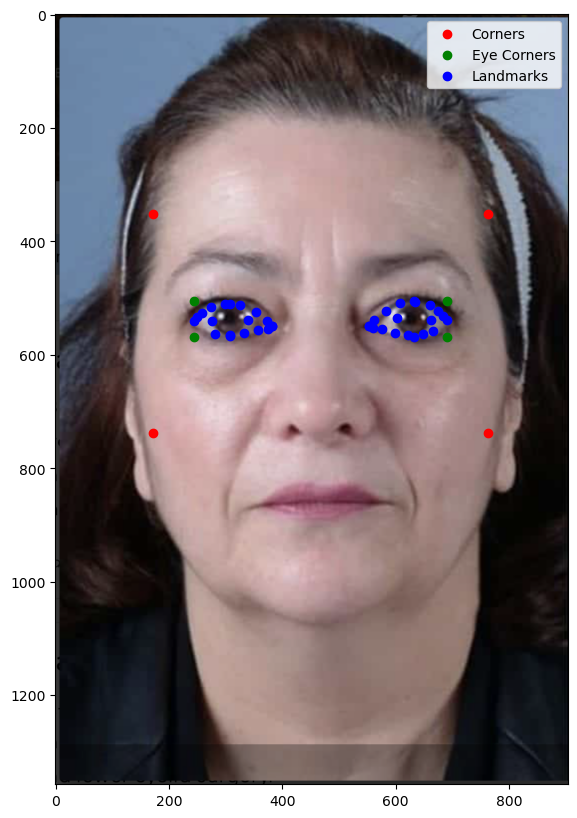

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# Plot the cropped eye region
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Draw rectangle or points for x_min, y_min, x_max, y_max
plt.scatter([x_min, x_min, x_max, x_max], [y_min, y_max, y_min, y_max], color='red', label='Corners')
plt.scatter([x_min_eye, x_min_eye, x_max_eye, x_max_eye], [y_min_eye, y_max_eye, y_min_eye, y_max_eye], color='green', label='Eye Corners')

# Plot x_coords and y_coords
if x_coords and y_coords:
    plt.scatter(x_coords, y_coords, color='blue', label='Landmarks')

plt.legend()
plt.show()